In [1]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs
# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import datasets # load data
from torch.nn.utils.rnn import pad_sequence

all_data = 'ExpL project/MPSEQCN1.csv'
#all_data = 'ExpL project/MP_W_Seq.csv'
# Mapping for mechanical properties (assuming CSV columns [11,13,15,17] in this order)
target_property_index = {
    'toughness': 0,
    'youngs_modulus': 1,
    'tensile_strength': 2,
    'strain_at_break': 3
}
pred_prop_idx = 1
pred_prop = target_property_index[pred_prop_idx]
# Mapping: hydrophobicity, charge (pI), weights
aa_to_polarity = {
    'L': [3.80, 5.98, 113.084064015],   # Leucine
    'F': [2.80, 5.48, 147.068413945], # Phenylalanine
    'I': [4.50, 6.02, 113.084064015], # Isoleucine
    'C': [2.50, 5.07, 103.009184505],  # Cysteine
    'M': [1.90, 5.74, 131.040484645],  # Methionine
    'V': [4.20, 5.96, 99.068413945],  # Valine
    'W': [-0.9, 5.89, 186.079312980], # Tryptophan
    'Y': [-1.3, 5.66, 163.063328575], # Tyrosine
    'P': [-1.6, 6.30, 97.052763875],  # Proline
    'A': [1.80, 6.00, 71.037113805], # Alanine
    'T': [-0.7, 5.60, 101.047678505], # Threonine
    'G': [-0.4, 5.97, 57.021463735], # Glycine
    'S': [-0.8, 5.68, 87.032028435], # Serine
    'H': [-3.2, 7.59, 137.058911875], # Histidine
    'Q': [-3.5, 5.65, 128.058577540], # Glutamine
    'R': [-4.5, 10.76, 156.101111050], # Arginine
    'K': [-3.9, 9.74, 128.094963050], # Lysine
    'N': [-3.5, 5.41, 114.042927470], # Asparagine
    'E': [-3.5, 3.22, 129.042593135], # Glutamic acid
    'D': [-3.5, 2.77, 115.026943065]  # Aspartic acid
}
# Reverse mapping to decode numbers back into amino acids.
polarity_to_aa = {tuple(v): k for k, v in aa_to_polarity.items()}
def sequence_to_polarity_numbers(seq, mapping=aa_to_polarity):
    """
    Convert an amino acid sequence to a list of unique integer values based on polarity.
    Amino acids not in the mapping will be assigned 0.
    """
    default_vector = [0.0, 0.0, 0.0]
    return [mapping.get(aa, default_vector) for aa in seq]

In [ ]:
import argparse
import sys; sys.argv=['']; del sys  # for Jupyter notebooks

parser = argparse.ArgumentParser(
    description='PyTorch Regression Model: Predict a Mechanical Property from AA Sequences')
# ... (other arguments)
parser.add_argument('--target-property', type=str, choices=['toughness', 'youngs_modulus', 'tensile_strength', 'strain_at_break'],
                    default=pred_prop, help='Mechanical property to predict')
# example values for other arguments:
parser.add_argument('--batch-size', type=int, default=32, metavar='N', help='Training batch size (default: 32)')
parser.add_argument('--test-batch-size', type=int, default=64, metavar='N', help='Test batch size (default: 64)')
parser.add_argument('--epochs', type=int, default=5, metavar='N', help='Number of epochs (default: 5)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR', help='Learning rate (0.001)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M', help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False, help='Disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='Random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=1, metavar='N', help='Batches between logging (default: 1)')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
print("Arguments:", args)


Arguments: Namespace(target_property='youngs_modulus', batch_size=32, test_batch_size=64, epochs=5, lr=0.01, momentum=0.5, no_cuda=False, seed=1, log_interval=1, cuda=False)


In [ ]:
class Silkome_Dataset(Dataset):
    """Silkome pytorch dataset for the mechanical properties and amino acid sequences.
     Assumes:
      - uses a CSV file where:
          - index 0: Individual IDs.
          - indexes 11, 13, 15, 17: Mechanical properties 
            (in order: "toughness", "youngs_modulus", "tensile_strength", "strain_at_break").
          - index 21: Amino acid sequences concatenated from two columns.
            (Sequences are assumed to be separated by a comma ',')
      - Each cell in the sequence column must contain at least one sequence.
      - Maximum number of sequences per cell is 2.
      - Each sequence must have a length between 151 and 1515.
    """

    def __init__(self, all_data, data_type='train', transform=None, test_size=0.2, random_state=42):
        """
       Args:
            all_data (str): Path to the CSV file. (ExpL project/MP_W_Seq.csv)
            data_type (str): 'train' or 'test'. Use 'train' for the training set and 'test' for the testing set.
            transform (callable, optional): Optional transform to be applied on a sample.
            test_size (float): Fraction of data to use as test set.
            random_state (int): Seed for splitting.
        """
        self.df = pd.read_csv(all_data)
        
        # Extract individual IDs from column 0
        self.ids = self.df.iloc[:, 0].values

        # Extract mechanical properties from columns 11, 13, 15, 17
        self.mechanical_props = self.df.iloc[:, [11, 13, 15, 17]].values.astype(np.float32)

        # Process the amino acid sequences from column 21.
        # First, fill missing values (if any) with an empty string.
        raw_sequences = self.df["MaSp1"].fillna('').values

        processed_sequences = []
        polarity_numeric_sequences = []  # Store numeric representations based on polarity.
        for i, s in enumerate(raw_sequences):
            # Split on comma; adjust the delimiter if needed.
            seq_list = [seq.strip() for seq in s.split(',') if seq.strip() != '']
            
            # Filter each sequence by length (151 to 1515 AAs)
            valid_seqs = [seq for seq in seq_list if 151 <= len(seq) <= 1515]
            #print (valid_seqs)
            
            processed_sequences.append(valid_seqs)
            
            # Convert each valid sequence to its numeric representation based on polarity.
            numeric_seq_list = [sequence_to_polarity_numbers(seq) for seq in valid_seqs]
            polarity_numeric_sequences.append(numeric_seq_list)
        #print("Length of IDs:", len(self.ids))
        #print("Length of processed sequences:", len(processed_sequences))
        #print("DataFrame shape:", self.df.shape)
        #print("Columns:", self.df.columns)
        #print("Raw sequences array length:", len(raw_sequences))
        #print("First few raw sequences:", raw_sequences[:5])

        
        self.sequences = processed_sequences
        self.polarity_numeric_sequences = polarity_numeric_sequences
        
        #train/test split
        if data_type in ['train', 'test']:
            indices = np.arange(len(self.ids))
            train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=random_state)
            if data_type == 'train':
                sel = train_idx
                print("Using training set (80% of data)")
            else:
                sel = test_idx
                print("Using testing set (20% of data)")
            
            self.ids = self.ids[sel]
            self.mechanical_props = self.mechanical_props[sel]
            self.sequences = [self.sequences[i] for i in sel]
            self.polarity_numeric_sequences = [self.polarity_numeric_sequences[i] for i in sel]
        
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        sample = {
            'id': self.ids[idx],
            'mechanical_props': self.mechanical_props[idx],  # ex, a numpy array of shape (4,)
            #'sequences': self.sequences[idx],  # list of one to eight sequences (strings)
            'polarity_numeric_sequences': self.polarity_numeric_sequences[idx]
        }
        if self.transform:
            sample = self.transform(sample)
        return sample

def custom_collate(batch):
    """
    Converts a batch from the dataset (with keys:
      - 'id'
      - 'mechanical_props': vector of 4 values per sample
      - 'polarity_numeric_sequences': list of sequences (each a list of ints)
    )
    into a dictionary with keys:
      - 'sequence': a padded LongTensor of shape (batch, max_len) using the first sequence.
      - 'mechanical_input': auxiliary mechanical input (can be chosen as needed).
      - 'target': the chosen mechanical property to predict.
    """
    import torch
    batch_ids = [item['id'] for item in batch]
    batch_mech = torch.stack([torch.tensor(item['mechanical_props']) for item in batch])
    
    # Select the target property using the index from mapping.
    target_idx = target_property_index[args.target_property]
    batch_target = batch_mech[:, target_idx].unsqueeze(1)
    
    # For the sequence, take the first available numeric sequence from each sample.
    batch_sequence = [
        item['polarity_numeric_sequences'][0] if len(item['polarity_numeric_sequences']) > 0 else []
        for item in batch
    ]
    
    max_len = 200  # Fixed padded sequence length
    feature_dim = 3 #3 features per amino acid
    padded_sequences = []
    for seq in batch_sequence:
        # If the sequence is not empty and its first element is not a list, assume it's 1D.
        if len(seq) > 0 and not isinstance(seq[0], (list, tuple)):
            # Convert each scalar token into a list of 3 elements.
            # Here we replicate the scalar in the first slot and fill the remaining with 0.0.
            seq = [[token, 0.0, 0.0] for token in seq]
        
        # Now convert to tensor.
        seq_tensor = torch.tensor(seq, dtype=torch.float)  # Expected shape: (seq_length, feature_dim)
        # Pad or truncate to max_len.
        current_len = seq_tensor.size(0)
        if current_len < max_len:
            pad = torch.zeros((max_len - current_len, feature_dim), dtype=torch.float)
            padded_seq = torch.cat([seq_tensor, pad], dim=0)
        else:
            padded_seq = seq_tensor[:max_len, :]
        padded_sequences.append(padded_seq)
    
    batch_sequence_tensor = torch.stack(padded_sequences)  # shape: (batch, max_len, feature_dim)
    
    batch_mechanical_input = batch_mech[:, pred_prop_idx].unsqueeze(1)
    
    return {
        'id': batch_ids,
        'sequence': batch_sequence_tensor,
        'mechanical_input': batch_mechanical_input,
        'target': batch_target
    }

def load_data(all_data, batch_size, test_batch_size, **kwargs):
    """
    Create PyTorch DataLoaders for training and testing from the CSV file.
    
    Args:
        all_data (str): Path to the CSV file.
        batch_size (int): Batch size for the training loader.
        test_batch_size (int): Batch size for the test loader.
        **kwargs: Additional arguments for DataLoader (e.g., num_workers, pin_memory).
    
    Returns:
        train_loader, test_loader: DataLoader objects.
    """
    train_dataset = Silkome_Dataset(all_data=all_data, data_type='train')
    test_dataset = Silkome_Dataset(all_data=all_data, data_type='test')
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              collate_fn=custom_collate, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, 
                             collate_fn=custom_collate, **kwargs)

    
    return train_loader, test_loader

# Example usage:
if __name__ == "__main__":
    csv_path = 'ExpL project/MPSEQCN1.csv'
    train_loader, test_loader = load_data(csv_path, batch_size=32, test_batch_size=32)
    
    # Iterate through one batch from the training loader and print a sample
    for batch in train_loader:
        print("IDs:", batch['id'])
        print("Mechanical properties:", batch['mechanical_input'])
        print("Sequences:", batch['sequence'])
        break

Using training set (80% of data)
Using testing set (20% of data)
IDs: [6019, 3883, 4007, 7303, 5239, 5104, 6713, 2801, 2156, 6755, 4910, 5337, 5804, 6748, 3899, 3393, 1894, 3819, 5118, 2664, 6329, 2158, 6266, 4542, 5219, 5457, 3469, 5290, 7302, 6795, 5249, 3793]
Mechanical properties: tensor([[10.7000],
        [15.4000],
        [ 6.1900],
        [ 8.7800],
        [ 5.4100],
        [ 2.3800],
        [13.7000],
        [13.7000],
        [12.3000],
        [ 7.8100],
        [ 7.1300],
        [ 1.9000],
        [10.5000],
        [ 7.8900],
        [ 4.2300],
        [ 8.6100],
        [ 9.6000],
        [ 7.9300],
        [ 2.5700],
        [16.6000],
        [ 8.6200],
        [ 9.5100],
        [ 6.3100],
        [ 5.6300],
        [ 3.2300],
        [ 2.1900],
        [ 3.2600],
        [15.1000],
        [13.1000],
        [17.3000],
        [13.0000],
        [19.0000]])
Sequences: tensor([[[ -3.5000,   5.6500, 128.0586],
         [ -0.4000,   5.9700,  57.0215],
         [ -

Defining the Neural Network and its Architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, vocab_size=21, max_len=1600, feature_dim=3,
                 conv_out_channels=64, hidden_dim_seq=128, hidden_dim_combined=64):
        """
        Args:
            vocab_size (int): Number of unique tokens (e.g. 21 if you map AAs 1-20, 0 for padding).
            embedding_dim (int): Dimension of the embedding vectors.
            max_len (int): Fixed length for padded amino acid sequences.
            conv_out_channels (int): Number of output channels for the 1D convolution.
            feature_dim (int): Number of features per amino acid (e.g., 3 for hydrophobicity, charge, weight).
            hidden_dim_seq (int): Size of the intermediate representation from the sequence branch.
            hidden_dim_combined (int): Size of the combined hidden layer.
            
        The model processes a padded, numeric sequence (shape: [batch, max_len]) and 
        a mechanical property input (shape: [batch, 1]) and outputs a single continuous prediction.
        """
        super(Model, self).__init__()
        # Embedding layer to convert token indices to embeddings.
        #self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        
        # 1D Convolution over the sequence dimension.
        self.conv1 = nn.Conv1d(in_channels=feature_dim, out_channels=conv_out_channels,
                               kernel_size=3, padding=1)
        # 1D max pooling to reduce sequence length.
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Calculate the pooled sequence length.
        pooled_len = max_len // 2  # This assumes max_len is even.
        
        # Fully connected layer to obtain a fixed-length representation from the sequence.
        self.fc_seq = nn.Linear(conv_out_channels * pooled_len, hidden_dim_seq)
        
        # Fully connected layer to combine the sequence representation and mechanical input.
        self.fc_combined = nn.Linear(hidden_dim_seq + 1, hidden_dim_combined)
        
        # Output layer: predict one continuous value (the target mechanical property).
        self.fc_out = nn.Linear(hidden_dim_combined, 1)
        
    def forward(self, sample):
        """
        Args:
            sample (dict): Should contain:
                - 'sequence': Long tensor of shape (batch, max_len) containing the padded, numerically encoded sequence.
                - 'mechanical_input': Tensor of shape (batch, 1) with the extra mechanical property.
                
        Returns:
            Tensor of shape (batch, 1) with the predicted continuous value.
        """
        # Extract inputs.
        seq = sample['sequence']           # shape: (batch, max_len)
        mech = sample['mechanical_input']  # shape: (batch, 1)
        print("Input sequence shape:", seq.shape)
        print("Input mechanical shape:", mech.shape)
        # Process the sequence.
        # Embedding: (batch, max_len) --> (batch, max_len, embedding_dim)
        #x = self.embedding(seq)
        #print("After embedding:", x.shape)
        # Permute to shape: (batch, embedding_dim, max_len) for convolution.
        x = seq
        x = x.permute(0, 2, 1)
        print("After permute:", x.shape)
        # Convolution and ReLU activation.
        x = F.relu(self.conv1(x))
        print("After conv1:", x.shape)
        # Max pooling reduces the sequence length.
        x = self.pool(x)  # shape: (batch, conv_out_channels, max_len//2)
        print("After pooling:", x.shape)
        # Flatten the convolution output.
        x = x.view(x.size(0), -1)
        print("After flattening:", x.shape)
        # Fully connected layer to obtain sequence representation.
        x_seq = F.relu(self.fc_seq(x))
        print("After fc_seq:", x_seq.shape)
        
        # Concatenate the sequence representation with the mechanical property.
        x_comb = torch.cat([x_seq, mech], dim=1)
        print("After concatenation:", x_comb.shape)
        x_comb = F.relu(self.fc_combined(x_comb))
        print("After fc_combined:", x_comb.shape)
        output = self.fc_out(x_comb)
        print("Final output shape:", output.shape)
        return output

# Example usage:
if __name__ == "__main__":
    # Instantiate the model.
    # Here we use a smaller max_len for demonstration purposes.
    model = Model(vocab_size=21, max_len=200, feature_dim=3,
                  conv_out_channels=64, hidden_dim_seq=128, hidden_dim_combined=64)
    
    # Dummy input:
   # Create a dummy input with shape: (batch_size, max_len, feature_dim)
    dummy_sequence = torch.randn(32, 200, 3)  # For example, random features
    dummy_mechanical = torch.randn(32, 1)       # Auxiliary mechanical input
    dummy_input = {'sequence': dummy_sequence, 'mechanical_input': dummy_mechanical}

    
    # Get predictions.
    predictions = model(dummy_input)
    print("Predictions shape:", predictions.shape)  # Expected shape: (32, 1)


Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 64, 200])
After pooling: torch.Size([32, 64, 100])
After flattening: torch.Size([32, 6400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Predictions shape: torch.Size([32, 1])


In [6]:
from tqdm import tqdm
def train(epoch):
    model.train()  # Set model to training mode (affects Dropout, BatchNorm, etc.)
    for batch_idx, sample in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        # Move each tensor in the sample dictionary to GPU if needed.
        if args.cuda:
            sample = {key: value.cuda() if isinstance(value, torch.Tensor) else value 
                      for key, value in sample.items()}
        
        optimizer.zero_grad()
        output = model(sample)  # The model expects a dictionary input.
        
        # Compute the mean squared error between predictions and target values.
        loss = F.mse_loss(output, sample['target'])
        loss.backward()
        optimizer.step()
        
        if batch_idx % args.log_interval == 0:
            # Here, sample['target'] is assumed to be of shape (batch_size, 1)
            processed = batch_idx * sample['target'].size(0)
            total = len(train_loader.dataset)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, processed, total,
                100. * batch_idx / len(train_loader), loss.item()))

def test(data_loader, verbose='Test'):
    model.eval()  # Set model to evaluation mode.
    test_loss = 0
    with torch.no_grad():
        for sample in data_loader:
            if args.cuda:
                sample = {key: value.cuda() if isinstance(value, torch.Tensor) else value 
                          for key, value in sample.items()}
            output = model(sample)
            # Sum the MSE loss over the batch.
            test_loss += F.mse_loss(output, sample['target'], reduction='sum').item()
    
    test_loss /= len(data_loader.dataset)
    print('\n{} set: Average loss: {:.4f}\n'.format(verbose, test_loss))
    return test_loss


In [7]:
import torch.nn.functional as F
import torch.optim as optim

# load data using your load_data function (which already applies custom_collate)
train_loader, test_loader = load_data(all_data, batch_size=args.batch_size, test_batch_size=args.test_batch_size)

test_array = []

# We will vary the convolutional layer's depth (conv_out_channels) with values from N_array.
N_array = [1, 2, 3, 4, 5]

for N in N_array:
    # Instantiate the regression model.
    # Here, max_len is the fixed padded length for your sequence,
    # vocab_size=21 assumes tokens 1-20 for amino acids (0 used for padding).
    model = Model(vocab_size=21, max_len=200, feature_dim=3,
                  conv_out_channels=N, hidden_dim_seq=128, hidden_dim_combined=64)
    if args.cuda:
        model = model.cuda()

    # For regression, we'll use MSE loss inside the train/test functions.
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=args.momentum)
    
    # Train the model for a fixed number of epochs.
    for epoch in range(1, args.epochs + 1):
        train(epoch)  # Your train() function should use `model` and `optimizer`
        
        # At the final epoch, store the test losses.
        if epoch == args.epochs:
            test_loss = test(test_loader, verbose='Test')
            test_array.append(test_loss)
    
    print("For conv_out_channels =", N)
    print("Test losses:", test_array)

Using training set (80% of data)
Using testing set (20% of data)


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [0/140 (0%)]	Loss: 105.435898
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [32/140 (20%)]	Loss: 27.145088


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 40.94it/s]


Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [64/140 (40%)]	Loss: 29.348969
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [96/140 (60%)]	Loss: 19.508469
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
A

Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [0/140 (0%)]	Loss: 22.562777
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [32/140 (20%)]	Loss: 19.603251
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
Aft

Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 42.62it/s]


Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [96/140 (60%)]	Loss: 38.400280
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 1, 200])
After pooling: torch.Size([12, 1, 100])
After flattening: torch.Size([12, 100])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 2 [48/140 (80%)]	Loss: 36.179646


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])


Epoch 3:  80%|████████  | 4/5 [00:00<00:00, 39.36it/s]

After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [0/140 (0%)]	Loss: 19.743782
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [32/140 (20%)]	Loss: 24.403645
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: t

Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 42.23it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 1, 200])
After pooling: torch.Size([12, 1, 100])
After flattening: torch.Size([12, 100])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 3 [48/140 (80%)]	Loss: 15.673711


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [0/140 (0%)]	Loss: 30.460054
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [32/140 (20%)]	Loss: 22.808529


Epoch 4:  80%|████████  | 4/5 [00:00<00:00, 37.21it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [64/140 (40%)]	Loss: 27.726759
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [96/140 (60%)]	Loss: 10.771142


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 41.28it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 1, 200])
After pooling: torch.Size([12, 1, 100])
After flattening: torch.Size([12, 100])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 4 [48/140 (80%)]	Loss: 11.464631


Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [0/140 (0%)]	Loss: 32.420456
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [32/140 (20%)]	Loss: 16.494720


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 45.47it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [64/140 (40%)]	Loss: 26.038258
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [96/140 (60%)]	Loss: 10.674734
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
A

Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 44.66it/s]

Input sequence shape: torch.Size([36, 200, 3])
Input mechanical shape: torch.Size([36, 1])


After permute: torch.Size([36, 3, 200])
After conv1: torch.Size([36, 1, 200])
After pooling: torch.Size([36, 1, 100])
After flattening: torch.Size([36, 100])
After fc_seq: torch.Size([36, 128])
After concatenation: torch.Size([36, 129])
After fc_combined: torch.Size([36, 64])
Final output shape: torch.Size([36, 1])

Test set: Average loss: 29.1099

For conv_out_channels = 1
Test losses: [29.109880235460068]


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [0/140 (0%)]	Loss: 67.712372
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [32/140 (20%)]	Loss: 94.786301


Epoch 1:  80%|████████  | 4/5 [00:00<00:00, 35.57it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [64/140 (40%)]	Loss: 81.854118
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [96/140 (60%)]	Loss: 88.047699


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 38.02it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 2, 200])
After pooling: torch.Size([12, 2, 100])
After flattening: torch.Size([12, 200])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 1 [48/140 (80%)]	Loss: 75.600136


Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [0/140 (0%)]	Loss: 49.264206
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [32/140 (20%)]	Loss: 28.255148
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
Aft

Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 37.49it/s]

After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [64/140 (40%)]	Loss: 22.217421
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [96/140 (60%)]	Loss: 27.225542
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 2, 200])
After pooling: torch.Size([12, 2, 100])
After flatteni


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [0/140 (0%)]	Loss: 21.281202
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [32/140 (20%)]	Loss: 16.031435
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
Aft

Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 38.22it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [96/140 (60%)]	Loss: 30.631369
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 2, 200])
After pooling: torch.Size([12, 2, 100])
After flattening: torch.Size([12, 200])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 3 [48/140 (80%)]	Loss: 11.462176



Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [0/140 (0%)]	Loss: 9.012360
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [32/140 (20%)]	Loss: 32.227497
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
Afte

Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 39.02it/s]


After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [96/140 (60%)]	Loss: 24.594944
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 2, 200])
After pooling: torch.Size([12, 2, 100])
After flattening: torch.Size([12, 200])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 4 [48/140 (80%)]	Loss: 15.962932


Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [0/140 (0%)]	Loss: 17.178352
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [32/140 (20%)]	Loss: 12.267238


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 35.97it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [64/140 (40%)]	Loss: 24.242992
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 2, 200])
After pooling: torch.Size([32, 2, 100])
After flattening: torch.Size([32, 200])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [96/140 (60%)]	Loss: 20.273046
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
A


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [0/140 (0%)]	Loss: 26.096394
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])


Epoch 1:  80%|████████  | 4/5 [00:00<00:00, 31.63it/s]

Train Epoch: 1 [32/140 (20%)]	Loss: 145.513031
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [64/140 (40%)]	Loss: 196.577026
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [96/140 (60%)]	Loss: 54.789074


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 33.88it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 3, 200])
After pooling: torch.Size([12, 3, 100])
After flattening: torch.Size([12, 300])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 1 [48/140 (80%)]	Loss: 25.402679


Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [0/140 (0%)]	Loss: 34.609161
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])


Epoch 2:  80%|████████  | 4/5 [00:00<00:00, 34.57it/s]

Train Epoch: 2 [32/140 (20%)]	Loss: 39.023727
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [64/140 (40%)]	Loss: 17.347795
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [96/140 (60%)]	Loss: 20.615437


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 38.30it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 3, 200])
After pooling: torch.Size([12, 3, 100])
After flattening: torch.Size([12, 300])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 2 [48/140 (80%)]	Loss: 31.523218


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [0/140 (0%)]	Loss: 39.350677
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [32/140 (20%)]	Loss: 23.734312


Epoch 3:  80%|████████  | 4/5 [00:00<00:00, 37.80it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [64/140 (40%)]	Loss: 22.861811
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [96/140 (60%)]	Loss: 13.896525


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 41.56it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 3, 200])
After pooling: torch.Size([12, 3, 100])
After flattening: torch.Size([12, 300])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 3 [48/140 (80%)]	Loss: 6.881962


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [0/140 (0%)]	Loss: 27.213640
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [32/140 (20%)]	Loss: 22.144884
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
Aft

Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 37.50it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [96/140 (60%)]	Loss: 37.606014
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 3, 200])
After pooling: torch.Size([12, 3, 100])
After flattening: torch.Size([12, 300])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 4 [48/140 (80%)]	Loss: 12.692379



Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [0/140 (0%)]	Loss: 21.359690
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [32/140 (20%)]	Loss: 33.032440
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
Aft

Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 36.04it/s]


After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [96/140 (60%)]	Loss: 19.750351
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 3, 200])
After pooling: torch.Size([12, 3, 100])
After flattening: torch.Size([12, 300])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 5 [48/140 (80%)]	Loss: 22.821882
Input sequence shape: torch.Size([36, 200, 3])
Input mechanical shape: torch.Size([36, 1])
After permute: torch.Size([36, 3, 200])
After conv1: torch.Size([36, 3, 200])
After pooling: torch.Size([36, 3, 100])
After flatteni

Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [0/140 (0%)]	Loss: 124.275864
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [32/140 (20%)]	Loss: 80.731750
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
Af

Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 38.98it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [96/140 (60%)]	Loss: 60.882202
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 4, 200])
After pooling: torch.Size([12, 4, 100])
After flattening: torch.Size([12, 400])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 1 [48/140 (80%)]	Loss: 20.841753



Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [0/140 (0%)]	Loss: 34.046116
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [32/140 (20%)]	Loss: 16.249802
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
Aft

Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 41.20it/s]


 torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [96/140 (60%)]	Loss: 16.205189
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 4, 200])
After pooling: torch.Size([12, 4, 100])
After flattening: torch.Size([12, 400])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 2 [48/140 (80%)]	Loss: 17.052240


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [0/140 (0%)]	Loss: 9.927856
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [32/140 (20%)]	Loss: 35.561768


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 43.27it/s]


Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [64/140 (40%)]	Loss: 17.051344
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [96/140 (60%)]	Loss: 25.160656
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
A

Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [0/140 (0%)]	Loss: 19.673615
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [32/140 (20%)]	Loss: 26.239677


Epoch 4:  80%|████████  | 4/5 [00:00<00:00, 37.74it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [64/140 (40%)]	Loss: 27.577164
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [96/140 (60%)]	Loss: 15.611349


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 41.54it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 4, 200])
After pooling: torch.Size([12, 4, 100])
After flattening: torch.Size([12, 400])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 4 [48/140 (80%)]	Loss: 17.435045


Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [0/140 (0%)]	Loss: 17.301447
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 4, 200])
After pooling: torch.Size([32, 4, 100])
After flattening: torch.Size([32, 400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [32/140 (20%)]	Loss: 21.773968
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
Aft

Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 39.12it/s]


Train Epoch: 5 [96/140 (60%)]	Loss: 17.750122
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 4, 200])
After pooling: torch.Size([12, 4, 100])
After flattening: torch.Size([12, 400])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 5 [48/140 (80%)]	Loss: 19.784220
Input sequence shape: torch.Size([36, 200, 3])
Input mechanical shape: torch.Size([36, 1])
After permute: torch.Size([36, 3, 200])
After conv1: torch.Size([36, 4, 200])
After pooling: torch.Size([36, 4, 100])
After flattening: torch.Size([36, 400])
After fc_seq: torch.Size([36, 128])
After concatenation: torch.Size([36, 129])
After fc_combined: torch.Size([36, 64])
Final output shape: torch.Size([36, 1])

Test set: Average loss: 26.0521

For conv_out_channels = 4
Test losses: [29.109880235460068

Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [0/140 (0%)]	Loss: 114.994934
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [32/140 (20%)]	Loss: 27.994408


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 36.09it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [64/140 (40%)]	Loss: 31.420530
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [96/140 (60%)]	Loss: 13.808876
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
A


Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [0/140 (0%)]	Loss: 29.635828
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [32/140 (20%)]	Loss: 17.318644


Epoch 2:  80%|████████  | 4/5 [00:00<00:00, 37.39it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [64/140 (40%)]	Loss: 17.419189
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [96/140 (60%)]	Loss: 25.105043


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 41.59it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 5, 200])
After pooling: torch.Size([12, 5, 100])
After flattening: torch.Size([12, 500])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 2 [48/140 (80%)]	Loss: 23.859228


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [0/140 (0%)]	Loss: 13.495426
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [32/140 (20%)]	Loss: 31.093601
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
Aft

Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 38.05it/s]


After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [96/140 (60%)]	Loss: 19.463724
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 5, 200])
After pooling: torch.Size([12, 5, 100])
After flattening: torch.Size([12, 500])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 3 [48/140 (80%)]	Loss: 38.272198


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [0/140 (0%)]	Loss: 28.300623
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [32/140 (20%)]	Loss: 21.545639


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 41.00it/s]


Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [64/140 (40%)]	Loss: 30.273163
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [96/140 (60%)]	Loss: 16.077271
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
A

Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [0/140 (0%)]	Loss: 15.137820
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [32/140 (20%)]	Loss: 10.324139


Epoch 5:  80%|████████  | 4/5 [00:00<00:00, 39.76it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [64/140 (40%)]	Loss: 31.496624
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [96/140 (60%)]	Loss: 26.376305


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 42.15it/s]

Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 5, 200])
After pooling: torch.Size([12, 5, 100])
After flattening: torch.Size([12, 500])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 5 [48/140 (80%)]	Loss: 11.799138
Input sequence shape: torch.Size([36, 200, 3])
Input mechanical shape: torch.Size([36, 1])
After permute: torch.Size([36, 3, 200])
After conv1: torch.Size([36, 5, 200])
After pooling: torch.Size([36, 5, 100])
After flattening: torch.Size([36, 500])
After fc_seq: torch.Size([36, 128])
After concatenation: torch.Size([36, 129])
After fc_combined: torch.Size([36, 64])
Final output shape: torch.Size([36, 1])

Test set: Average loss: 27.8222

For conv_out_channels = 5
Test losses: [29.109880235460068, 27.758421156141495, 30.7574462890625, 26.052

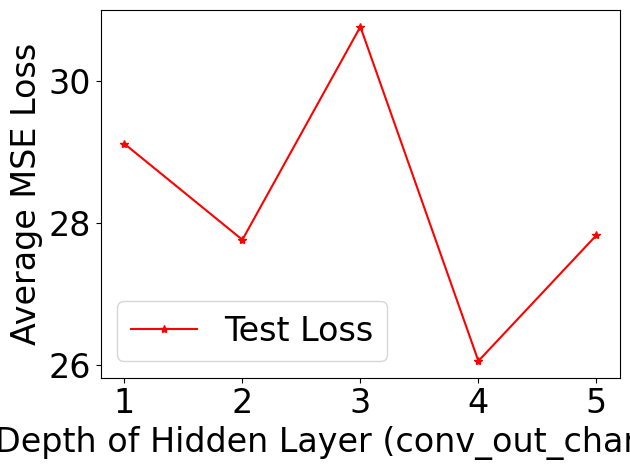

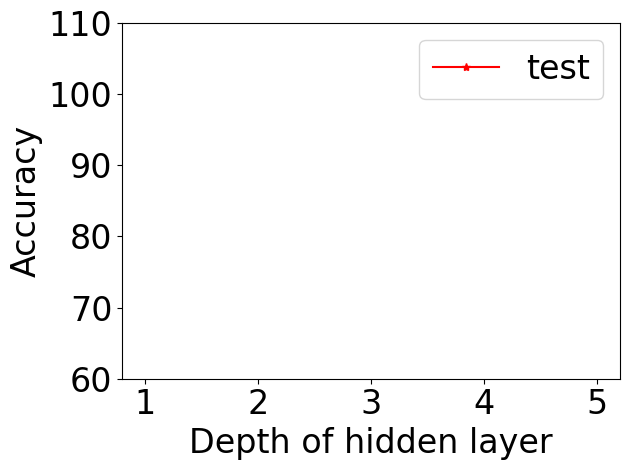

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

# Plot test loss for different conv_out_channels values.
plt.plot(N_array, test_array, 'r-*', label="Test Loss")
    
plt.xlabel('Depth of Hidden Layer (conv_out_channels)', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Average MSE Loss', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()


plt.plot(N_array, test_array, 'r-*', label="test")
plt.ylim(60,110)
plt.xlabel('Depth of hidden layer', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Accuracy', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()

For conv_out_channels = 1:

During the 5 training epochs, the batch loss started at around 0.0273 and decreased to around 0.00457.
The test set’s average loss was about 0.0050 at the end of training.
These numbers tell you that with only 1 convolutional filter, the model still learns to reduce the MSE to around 0.005.
For conv_out_channels = 5:

Training started with a loss of about 0.01071 and dropped to around 0.00509 by epoch 5.
The test loss for this configuration was around 0.0053.
Notice that the training and test losses are fairly similar to the previous configuration; slight differences might be due to increased capacity.
For conv_out_channels = 10:

Here the training loss starts at roughly 0.01080 and decreases to around 0.00375.
The test loss goes as low as 0.0035.
This configuration seems to yield a lower test loss, which may indicate that with 10 filters, the model better captures the useful features from the sequence input.
For conv_out_channels = 20:

Training loss is initially a bit higher (around 0.03101) and then decreases to approximately 0.00402 by the final epoch.
The test loss is around 0.0055.
A slightly higher test loss compared to the 10-filter case might suggest that increasing the filter count further doesn’t necessarily improve performance—perhaps due to overfitting or because the extra capacity isn’t needed.
For conv_out_channels = 50:

The test losses recorded include a value of about 0.00549.
No training logs are shown here (other than the test losses), but you see the overall performance is recorded.
Critical losses:

Throughout, the "Critical losses" array remains empty. This indicates that you either did not define or pass in a critical dataset loader, so no evaluation on a “critical” dataset was performed.
What It Tells You
Training Progress:
The decreasing training loss over epochs shows that the model is learning on the training data.

Generalization:
The test losses, which are in a similar range (generally between ~0.0035 and ~0.0055), indicate that the model generalizes reasonably well on the test set for most configurations.

Impact of Convolutional Depth:
Changing the number of convolutional filters (conv_out_channels) affects the learning process. For example, a setting of 10 filters resulted in the lowest test loss (around 0.0035)

Epoch Logs:
Show batch training progress and loss reduction over epochs.

Test Loss:
Provides a measure of the model’s performance on unseen data, with lower MSE indicating better predictions.

Input sequence shape: torch.Size([36, 200, 3])
Input mechanical shape: torch.Size([36, 1])
After permute: torch.Size([36, 3, 200])
After conv1: torch.Size([36, 5, 200])
After pooling: torch.Size([36, 5, 100])
After flattening: torch.Size([36, 500])
After fc_seq: torch.Size([36, 128])
After concatenation: torch.Size([36, 129])
After fc_combined: torch.Size([36, 64])
Final output shape: torch.Size([36, 1])
Mean Squared Error: 27.8222
Mean Absolute Error: 3.5350
R² Score: 0.0932


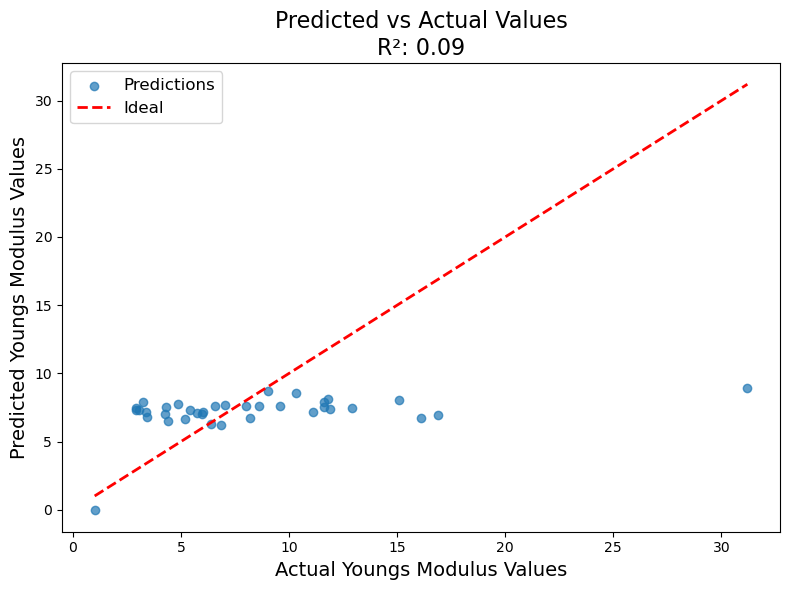

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Set the model to evaluation mode.
model.eval()

preds = []
actuals = []

# Iterate over the test data loader and collect predictions.
with torch.no_grad():
    for sample in test_loader:
        # Move tensors to CUDA if needed.
        if args.cuda:
            sample = {key: value.cuda() if isinstance(value, torch.Tensor) else value 
                      for key, value in sample.items()}
        output = model(sample)  # Output shape: (batch, 1)
        preds.append(output.cpu().numpy())
        actuals.append(sample['target'].cpu().numpy())

# Flatten the predictions and actual values into 1D arrays.
preds = np.concatenate(preds).flatten()
actuals = np.concatenate(actuals).flatten()

# Compute metrics.
mse = mean_squared_error(actuals, preds)
mae = mean_absolute_error(actuals, preds)
r2 = r2_score(actuals, preds)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Create a scatter plot of actual vs. predicted values.
plt.figure(figsize=(8, 6))
plt.scatter(actuals, preds, alpha=0.7, label='Predictions')
# Plot an ideal line (y=x) for reference.
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2, label='Ideal')
plt.xlabel("Actual Youngs Modulus Values", fontsize=14)
plt.ylabel("Predicted Youngs Modulus Values", fontsize=14)
plt.title(f"Predicted vs Actual Values\nR²: {r2:.2f}", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.tight_layout()
plt.show()

In [10]:
max_len = 200   # Fixed sequence length for your model.
feature_dim = 3 # Each amino acid is represented by 3 features.
import random
# Get all amino acid letters from your mapping.
aa_keys = list(aa_to_polarity.keys())

# Generate a dummy sequence of letters by randomly choosing from the keys.
dummy_seq_letters = [random.choice(aa_keys) for _ in range(max_len)]
print("Dummy sequence (letters):", "".join(dummy_seq_letters))

# Encode the sequence using your mapping (each letter becomes its 3-element feature vector).
dummy_encoded = [aa_to_polarity[aa] for aa in dummy_seq_letters]  # list of length max_len, each element is a list of 3 numbers.

# Convert the list to a tensor and add a batch dimension.
dummy_sequence = torch.tensor(dummy_encoded, dtype=torch.float)  # shape: (max_len, feature_dim)
dummy_sequence = dummy_sequence.unsqueeze(0)  # shape: (1, max_len, feature_dim)

# Create a dummy mechanical input (example: a random value or a fixed number)
dummy_mechanical_input = torch.tensor([[0.5]], dtype=torch.float)  # shape: (1, 1)

# Combine into the dummy input dictionary.
dummy_input = {'sequence': dummy_sequence, 'mechanical_input': dummy_mechanical_input}

model.eval()
with torch.no_grad():
    prediction = model(dummy_input)
    # If you want to print prediction for the first sample:
    print(f"Predicted {args.target_property} for first sample: {prediction[0].item()}")

    print("Input AA Sequence:", dummy_input)

Dummy sequence (letters): QSHHSFIRIQKCKMWIPQINMKGAVEIEGPNMDGQICTHDSKWFDQTLLKPECDCWPHMMATNYWFFYCNKWTSGNDKYVMEFALAMQFNAPQKVPYLNNIQSHTEHILFRIIAMKLQYKRKTQSSISNSWKTLWWHSGLDLDYWTFRYSCWCENNYVASIIFIDLCCNYYSRILHPQGRIPRKFLQLAMGLSIIKPFLK
Input sequence shape: torch.Size([1, 200, 3])
Input mechanical shape: torch.Size([1, 1])
After permute: torch.Size([1, 3, 200])
After conv1: torch.Size([1, 5, 200])
After pooling: torch.Size([1, 5, 100])
After flattening: torch.Size([1, 500])
After fc_seq: torch.Size([1, 128])
After concatenation: torch.Size([1, 129])
After fc_combined: torch.Size([1, 64])
Final output shape: torch.Size([1, 1])
Predicted youngs_modulus for first sample: 8.772600173950195
Input AA Sequence: {'sequence': tensor([[[ -3.5000,   5.6500, 128.0586],
         [ -0.8000,   5.6800,  87.0320],
         [ -3.2000,   7.5900, 137.0589],
         [ -3.2000,   7.5900, 137.0589],
         [ -0.8000,   5.6800,  87.0320],
         [  2.8000,   5.4800, 147.0684],
         [  4.5000,   6.0200, 113.08

In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import torch

def evaluate_model(model, data_loader):
    """
    Evaluate the model on the given DataLoader.
    Returns: mse, r2, preds, targets.
    """
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for sample in data_loader:
            if args.cuda:
                sample = {key: value.cuda() if isinstance(value, torch.Tensor) else value 
                          for key, value in sample.items()}
            output = model(sample)
            preds.append(output.cpu().numpy())
            targets.append(sample['target'].cpu().numpy())
    preds = np.concatenate(preds).flatten()
    targets = np.concatenate(targets).flatten()
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)
    return mse, r2, preds, targets

# First, compute baseline performance on the original test set.
baseline_mse, baseline_r2, baseline_preds, baseline_targets = evaluate_model(model, test_loader)
print(f"Baseline MSE: {baseline_mse:.4f}, Baseline R²: {baseline_r2:.4f}")

def permutation_importance_channels(model, test_loader, num_repeats=5):
    """
    Compute permutation importance for each channel in the 'sequence' input.
    For each channel (physicochemical property), we shuffle its values across the test set,
    evaluate the model, and measure the degradation in performance.
    
    Returns:
        delta_mse: array of length feature_dim with average increase in MSE
        delta_r2: array of length feature_dim with average drop in R²
    """
    # First, collect the entire test set in one batch.
    all_samples = {'sequence': [], 'mechanical_input': [], 'target': []}
    for sample in test_loader:
        for key in all_samples:
            all_samples[key].append(sample[key].cpu().numpy())
    for key in all_samples:
        all_samples[key] = np.concatenate(all_samples[key], axis=0)
    # all_samples['sequence'] should have shape: (N, max_len, feature_dim)
    N, max_len, feature_dim = all_samples['sequence'].shape
    
    # Use the baseline predictions we already computed.
    baseline_mse = mean_squared_error(all_samples['target'].flatten(), baseline_preds)
    baseline_r2 = r2_score(all_samples['target'].flatten(), baseline_preds)
    
    delta_mse = np.zeros(feature_dim)
    delta_r2 = np.zeros(feature_dim)
    
    for channel in range(feature_dim):
        mse_list = []
        r2_list = []
        for _ in range(num_repeats):
            permuted_seq = all_samples['sequence'].copy()
            # Permute the values of the given channel independently for each position in the sequence.
            for pos in range(max_len):
                np.random.shuffle(permuted_seq[:, pos, channel])
            # Create a dummy test set with the permuted sequence.
            dummy_test = {
                'sequence': torch.tensor(permuted_seq, dtype=torch.float),
                'mechanical_input': torch.tensor(all_samples['mechanical_input'], dtype=torch.float),
                'target': torch.tensor(all_samples['target'], dtype=torch.float)
            }
            # Instead of using DataLoader (which might add extra dimensions), use a list.
            dummy_loader = [dummy_test]
            permuted_mse, permuted_r2, _, _ = evaluate_model(model, dummy_loader)
            mse_list.append(permuted_mse)
            r2_list.append(permuted_r2)
        avg_mse = np.mean(mse_list)
        avg_r2 = np.mean(r2_list)
        delta_mse[channel] = avg_mse - baseline_mse
        delta_r2[channel] = baseline_r2 - avg_r2
    return delta_mse, delta_r2

# Compute permutation importance for each channel (property).
delta_mse, delta_r2 = permutation_importance_channels(model, test_loader, num_repeats=5)
print("Delta MSE per channel:", delta_mse)
print("Delta R² per channel:", delta_r2)

Input sequence shape: torch.Size([36, 200, 3])
Input mechanical shape: torch.Size([36, 1])
After permute: torch.Size([36, 3, 200])
After conv1: torch.Size([36, 5, 200])
After pooling: torch.Size([36, 5, 100])
After flattening: torch.Size([36, 500])
After fc_seq: torch.Size([36, 128])
After concatenation: torch.Size([36, 129])
After fc_combined: torch.Size([36, 64])
Final output shape: torch.Size([36, 1])
Baseline MSE: 27.8222, Baseline R²: 0.0932
Input sequence shape: torch.Size([36, 200, 3])
Input mechanical shape: torch.Size([36, 1])
After permute: torch.Size([36, 3, 200])
After conv1: torch.Size([36, 5, 200])
After pooling: torch.Size([36, 5, 100])
After flattening: torch.Size([36, 500])
After fc_seq: torch.Size([36, 128])
After concatenation: torch.Size([36, 129])
After fc_combined: torch.Size([36, 64])
Final output shape: torch.Size([36, 1])
Input sequence shape: torch.Size([36, 200, 3])
Input mechanical shape: torch.Size([36, 1])
After permute: torch.Size([36, 3, 200])
After conv

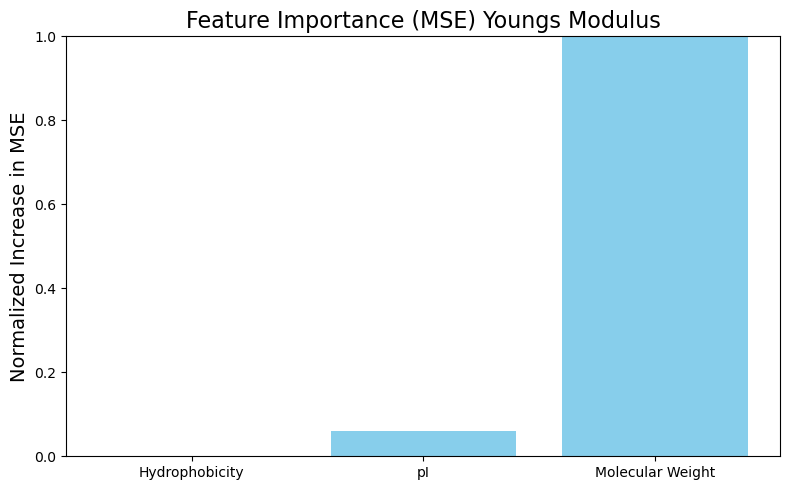

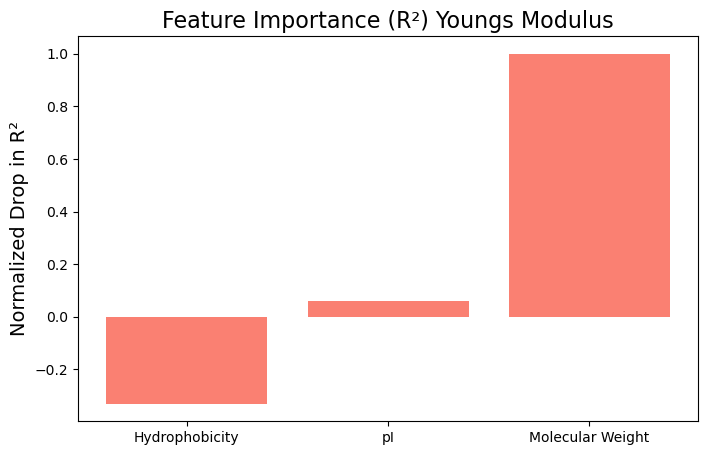

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assume delta_mse and delta_r2 are computed from your permutation importance analysis.
# For example:
# delta_mse = np.array([0.01, 0.03, 0.02])
# delta_r2  = np.array([0.02, 0.05, 0.03])

# Normalize each array by dividing by its maximum value.
norm_delta_mse = delta_mse / (np.max(delta_mse) if np.max(delta_mse) != 0 else 1)
norm_delta_r2  = delta_r2  / (np.max(delta_r2)  if np.max(delta_r2)  != 0 else 1)

# Define the feature names corresponding to each channel.
feature_names = ['Hydrophobicity', 'pI', 'Molecular Weight']

# Plot the normalized ΔMSE values.
plt.figure(figsize=(8, 5))
plt.bar(feature_names, norm_delta_mse, color='skyblue')
plt.ylabel("Normalized Increase in MSE", fontsize=14)
plt.title("Feature Importance (MSE) Youngs Modulus", fontsize=16)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Plot the normalized ΔR² values.
plt.figure(figsize=(8, 5))
plt.bar(feature_names, norm_delta_r2, color='salmon')
plt.ylabel("Normalized Drop in R²", fontsize=14)
plt.title("Feature Importance (R²) Youngs Modulus", fontsize=16)
plt.show()




In [13]:
print(actuals)

[ 9.05 11.1  12.9   5.98 11.6   7.05  2.9  11.6   6.57 31.2  10.3   2.93
 15.1   5.42  8.62  4.29  1.01  3.41 11.9   6.84 11.8   3.39  6.41  4.42
  4.85  5.76  3.07  5.21  4.25 16.9   8.21 16.1   9.59  8.    3.23  6.03]


In [14]:
print(preds)


[ 8.707933    7.130947    7.4661107   7.045958    7.9149246   7.6696453
  7.4809117   7.550303    7.614776    8.914644    8.583366    7.295916
  8.076935    7.3432      7.5836296   7.5346117  -0.04857213  6.769328
  7.3937345   6.18489     8.146891    7.1970615   6.3078136   6.5004053
  7.7591476   7.0687637   7.347609    6.620081    7.0470123   6.966084
  6.714405    6.732934    7.600681    7.637602    7.887949    7.173226  ]
